<a href="https://colab.research.google.com/github/Selva-Subramanian/Zomato-restaurant-clustering-Sentiment-Analysis/blob/main/ZOMATO_RESTAURANT_CLUSTERING_AND_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Zomato is an Indian restaurant aggregator and food delivery start-up founded by Deepinder Goyal and Pankaj Chaddah in 2008. Zomato provides information, menus and user-reviews of restaurants, and also has food delivery options from partner restaurants in select cities.

India is quite famous for its diverse multi cuisine available in a large number of restaurants and hotel resorts, which is reminiscent of unity in diversity. Restaurant business in India is always evolving. More Indians are warming up to the idea of eating restaurant food whether by dining outside or getting food delivered. The growing number of restaurants in every state of India has been a motivation to inspect the data to get some insights, interesting facts and figures about the Indian food industry in each city. So, this project focuses on analysing the Zomato restaurant data for each city in India.

The Project focuses on Customers and Company, you have  to analyze the sentiments of the reviews given by the customer in the data and made some useful conclusion in the form of Visualizations. Also, cluster the zomato restaurants into different segments. The data is vizualized as it becomes easy to analyse data at instant. The Analysis also solve some of the business cases that can directly help the customers finding the Best restaurant in their locality and for the company to grow up and work on the fields they are currently lagging in.

This could help in clustering the restaurants into segments. Also the data has valuable information around cuisine and costing which can be used in cost vs. benefit analysis

Data could be used for sentiment analysis. Also the metadata of reviewers can be used for identifying the critics in the industry. 

# **Attribute Information**

## **Zomato Restaurant names and Metadata**
Use this dataset for clustering part

1. Name : Name of Restaurants

2. Links : URL Links of Restaurants

3. Cost : Per person estimated Cost of dining

4. Collection : Tagging of Restaurants w.r.t. Zomato categories

5. Cuisines : Cuisines served by Restaurants

6. Timings : Restaurant Timings

## **Zomato Restaurant reviews**
Merge this dataset with Names and Matadata and then use for sentiment analysis part

1. Restaurant : Name of the Restaurant

2. Reviewer : Name of the Reviewer

3. Review : Review Text

4. Rating : Rating Provided by Reviewer

5. MetaData : Reviewer Metadata - No. of Reviews and followers

6. Time: Date and Time of Review

7. Pictures : No. of pictures posted with review

In [1]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b> Importing the required libraries

In [373]:
# for numerical computation
import numpy as np
from operator import add
import math
# for data manipulation 
import pandas as pd
# for creating copies
import copy

# for plotting visuals
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

# for ease of view
from google.colab import data_table
data_table.disable_dataframe_formatter()

# Exploratory Data Analysis
from wordcloud import WordCloud
from prettytable import PrettyTable

# model building
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [374]:
# load the dataset
working_dir_path = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/CP4 - Unsupervised - Clustering/'
df1 = pd.read_csv(working_dir_path + 'Zomato Restaurant names and Metadata.csv')
df2 = pd.read_csv(working_dir_path + 'Zomato Restaurant reviews.csv')

### <b> Data Inspection

In [375]:
# sample of the dataset
df1.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [376]:
# brief info of the dataset 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB


In [377]:
# brief description of the dataset
pd.set_option('display.max_rows', None)
df1.describe()

,Name,Links,Cost,Collections,Cuisines,Timings
count,105,105,105,51,105,104
unique,105,105,29,42,92,77
top,Hotel Zara Hi-Fi,https://www.zomato.com/hyderabad/la-la-land-ba...,500,Food Hygiene Rated Restaurants in Hyderabad,"North Indian, Chinese",11 AM to 11 PM
freq,1,1,13,4,4,6


In [378]:
# columns in the datset
df1.columns

Index(['Name', 'Links', 'Cost', 'Collections', 'Cuisines', 'Timings'], dtype='object')

#### All restaurants have links and it is not much useful so let's just drop it. 


In [379]:
# Drop columns
df1 = df1.drop(['Links'], axis=1)

In [380]:
# replace null values with a string
df1 = df1.fillna('no info')
df1['Timings'][30] = 'no info'

In [381]:
# change datatype of 'Cost' feature
df1['Cost'] = df1['Cost'].apply(lambda x: int(x.replace(',','')))

In [382]:
# formatting the string in  Timings feature
word_list = [[['noon','Noon','PM'],['p.m.']],[['midnight','Midnight','AM'],['a.m.']]]
for i in word_list:
  j = i[1][0]
  for k in i[0]:
    df1['Timings'] = df1['Timings'].str.replace(k,j)

### <b> Exploratory Data Analysis

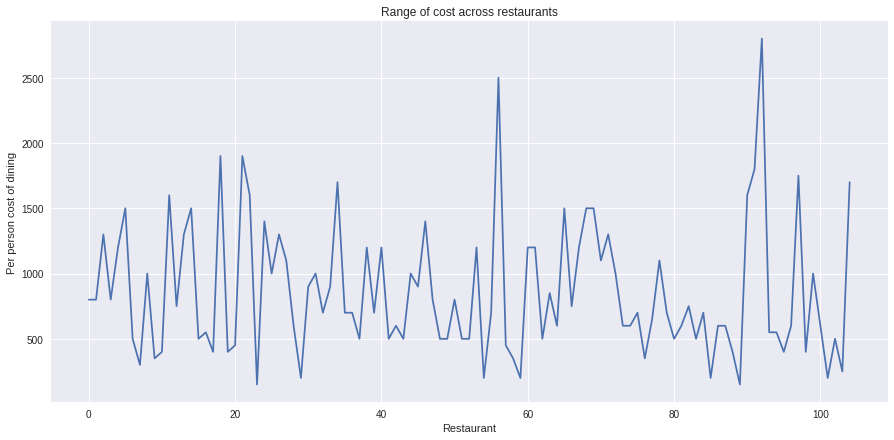

min: 150.0, IQR1:500.0, avg:700.0, IQR3: 1200.0, max: 2800.0


In [383]:
# Analysis of the feature 'Cost'
plt.figure(figsize=(15,7))
df1['Cost'].plot(kind='line')
plt.title("Range of cost across restaurants")
plt.xlabel("Restaurant")
plt.ylabel("Per person cost of dining")
plt.show()
print(f"min: {df1['Cost'].describe()[3]}, IQR1:{df1['Cost'].describe()[4]}, avg:{df1['Cost'].describe()[5]}, IQR3: {df1['Cost'].describe()[6]}, max: {df1['Cost'].describe()[7]}")

#### Most of the restaurants cost of dining per person lies in the range of 500 and 1200 with minimum cost of dining per person at 150 and maximum at 2800 and average cost at 700.

##### <b> Unique values in our features





In [384]:
# initialize empty lists
Unique_Collections = []
Unique_Cuisines = []

# features list
unique_list = [Unique_Collections, Unique_Cuisines]

# logic to extract unique values in the features
sum = 0
for i in df1.columns[2:-1]:
  l = unique_list[sum]
  sum += 1
  for j in range(len(df1[i])):
    for k in list(df1[i])[j].split(','):
      if k not in l and k[1:] not in l:
        if k[0]==' ':
          l.append(k[1:])
        else:
          l.append(k)

# number of unique items in the features
print(f"Total unique values in the feature 'Cost' is {len(df1['Cost'].value_counts())}\n")
for n,m in enumerate(df1.columns[2:-1]):
  print(f"Total unique values in the feature '{m}' is {len(unique_list[n])}\n")

Total unique values in the feature 'Cost' is 29

Total unique values in the feature 'Collections' is 38

Total unique values in the feature 'Cuisines' is 44



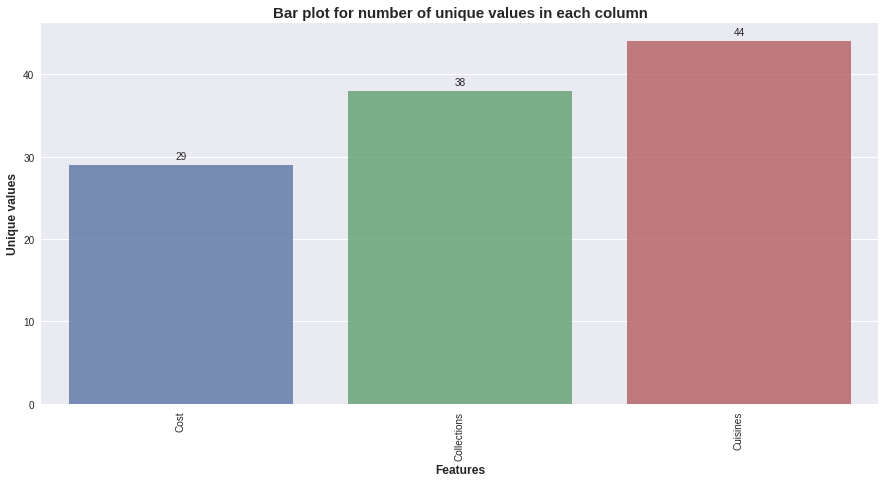

In [385]:
#Counting unique value of features
feature_names = ['Cost', 'Collections', 'Cuisines']
cost = len(df1['Cost'].value_counts())
collections = len(unique_list[0])
cuisines = len(unique_list[1])
feature_count = [cost, collections, cuisines]
f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=feature_names, y=feature_count, alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

In [386]:
# count of unique items in the features
features = ['Collections', 'Cuisines']

# initialize empty dictionaries
unique_count = {}
m = {}

# update unique values of 'Cost' and its frequency of occurence
for l in df1['Cost'].unique():
  m[l] = list(df1['Cost'].values).count(l)
unique_count['Cost'] = m
sum = 0

# initialize empty lists
collections_feature_list = []
cuisines_feature_list = []

# update unique values of 'Collections' and 'Cuisines' 
for i in unique_list:
  if i == unique_list[0]:
    df1[features[sum]] = df1[features[sum]].apply(lambda x: x.split(','))
    df1[features[sum]].apply(lambda x: collections_feature_list.extend(x))
    collections_feature_list = [x[1:] if x[0]==' ' else x[:] for x in collections_feature_list]
  else:
    df1[features[sum]] = df1[features[sum]].apply(lambda x: x.split(','))
    df1[features[sum]].apply(lambda x: cuisines_feature_list.extend(x))
    cuisines_feature_list = [x[1:] if x[0]==' ' else x[:] for x in cuisines_feature_list]
  
  # empty dict for 'Collections' and 'Cuisines'
  k = {}
  # update frequency of occurence
  for j in i:
    if i == unique_list[0]:
      k[j] = collections_feature_list.count(j)
    else:
      k[j] = cuisines_feature_list.count(j)  
  unique_count[features[sum]] = k
  feature_list = []
  sum += 1  

#### *Top 25 most frequent values of the features*

In [387]:
# create a table for a better visual
table = PrettyTable(['SL', 'Cost', 'Collections', 'Cuisines'])
for i in range(1,26):
  table.add_row([i, sorted(unique_count['Cost'].items(), key=lambda x: x[1],reverse = True)[i], sorted(unique_count['Collections'].items(), key=lambda x: x[1], reverse = True)[i], sorted(unique_count['Cuisines'].items(), key=lambda x: x[1], reverse = True)[i]])
table

SL,Cost,Collections,Cuisines
1,"(600, 10)","('Great Buffets', 11)","('Chinese', 43)"
2,"(700, 8)","('Food Hygiene Rated Restaurants in Hyderabad', 8)","('Continental', 21)"
3,"(1200, 7)","('Live Sports Screenings', 7)","('Biryani', 16)"
4,"(1000, 6)","(""Hyderabad's Hottest"", 7)","('Asian', 15)"
5,"(400, 6)","('Corporate Favorites', 6)","('Fast Food', 15)"
6,"(800, 5)","('Top-Rated', 5)","('Italian', 14)"
7,"(1500, 5)","('Gold Curated', 5)","('Desserts', 13)"
8,"(200, 5)","('Trending This Week', 5)","('South Indian', 9)"
9,"(1300, 4)","('Best Bars & Pubs', 4)","('Bakery', 7)"
10,"(350, 3)","('Sunday Brunches', 4)","('Kebab', 6)"


In [388]:
# text for word cloud generation
features = ['Collections', 'Cuisines']

# text corpus of 'Collections' and 'Cuisines'
for i in features:
  if i == 'Collections': 
    collections_feature_list_wo_no_info = []
    for j in collections_feature_list:
      if j != 'no info':
        collections_feature_list_wo_no_info.append(j)
  else:
     for n, m in enumerate(cuisines_feature_list):
      if m in ['North Indian', 'South Indian', 'Street Food']:
        if m == 'North Indian':
          cuisines_feature_list[n] = 'NorthIndian'
        elif m == 'South Indian':
          cuisines_feature_list[n] = 'SouthIndian'
        else:
          cuisines_feature_list[n] = 'StreetFood'

collections_text = ','.join(collections_feature_list_wo_no_info)
cuisines_text = ','.join(cuisines_feature_list)
    
# text corpus of 'Cost'
cost_text = df1['Cost'].value_counts()
cost_text.index = cost_text.index.map(str)

#### *Word cloud for the feature* ***'Cost'***

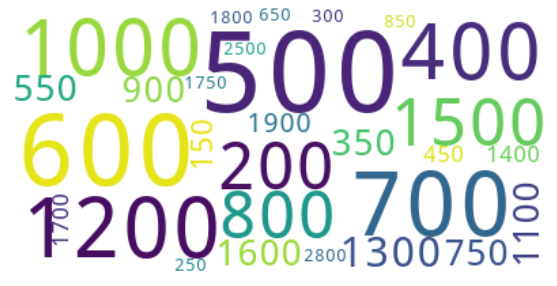

In [389]:
# Creating word_cloud with text as argument in .generate_from_frequencies() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate_from_frequencies(cost_text)

# Display the generated Word Cloud
plt.figure(figsize=(20,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### *Word cloud for the feature* ***'Collections'*** 

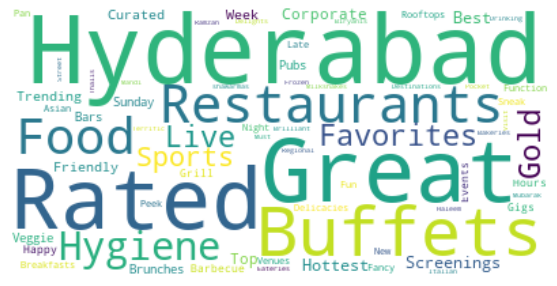

In [390]:
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(collections_text)

# Display the generated Word Cloud
plt.figure(figsize=(20,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### *Word cloud for the feature* ***'Cuisines'***

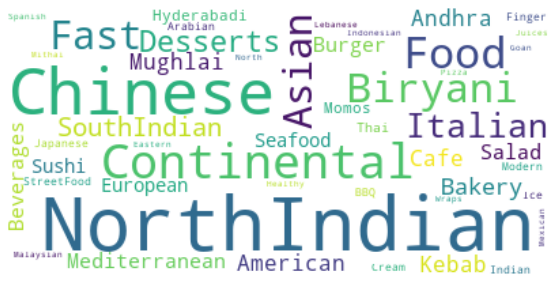

In [391]:
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(cuisines_text)

# Display the generated Word Cloud
plt.figure(figsize=(20,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### <b> Feature Engineering

#### Clustering is based on similarity which is measured using distance, so it is necessary to have numerical(continuous) columns so as to quantify distance and compute similarity. Let's engineer such features.

In [392]:
# encoded collections
l1 = list(unique_count['Collections'])
c1_dict = {}
for i,j in enumerate(l1):
  c1_dict[j] = i+1

df1['encoded collections'] = copy.deepcopy(df1['Collections'].values)
for k in df1['encoded collections']:
  for l,m in enumerate(k):
    if str(m)[0] == ' ':
      k[l] = c1_dict[str(m)[1:]]
    else:
      k[l] = c1_dict[m]

In [393]:
# encoded cuisines
l2 = list(unique_count['Cuisines'])
c2_dict = {}
for i,j in enumerate(l2):
  c2_dict[j] = i+1

df1['encoded cuisines'] = copy.deepcopy(df1['Cuisines'].values)
for k in df1['encoded cuisines']:
  for l,m in enumerate(k):
    if str(m)[0] == ' ':
      k[l] = c2_dict[str(m)[1:]]
    else:
      k[l] = c2_dict[m]

In [394]:
# function that returns the similarity
def similarity(m, n):
  cl = []
  for i in m:
    sum = 0
    for j in i:
      if j in m[n]:
        sum += 100
    cl.append(sum)
  return cl

In [395]:
# collections quantified
collections_value = similarity(df1['encoded collections'],0)
for i in range(1, len(df1['encoded collections'])):
  to_add = similarity(df1['encoded collections'],i)
  collections_value = list(map(add, collections_value, to_add))

In [396]:
# cuisines quantified
cuisines_value = similarity(df1['encoded cuisines'],0)
for i in range(1, len(df1['encoded cuisines'])):
  to_add = similarity(df1['encoded cuisines'],i)
  cuisines_value = list(map(add, cuisines_value, to_add))

In [397]:
# create new features for clustering
df1['collections value'] = collections_value
df1['collections value'][df1['collections value'] == 5400] = 0
df1['cuisines value'] = cuisines_value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [398]:
# overview of refined dataset
data_table.DataTable(df1, include_index=False, num_rows_per_page=25)

,Name,Cost,Collections,Cuisines,Timings,encoded collections,encoded cuisines,collections value,cuisines value
0,Beyond Flavours,800,"[Food Hygiene Rated Restaurants in Hyderabad, ...","[Chinese, Continental, Kebab, European, So...","12p.m. to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)","[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]",4200,14400
1,Paradise,800,[Hyderabad's Hottest],"[Biryani, North Indian, Chinese]",11 a.m. to 11 p.m.,[7],"[7, 6, 1]",700,12000
2,Flechazo,1300,"[Great Buffets, Hyderabad's Hottest]","[Asian, Mediterranean, North Indian, Desserts]","11:30 a.m. to 4:30 p.m., 6:30 p.m. to 11 p.m.","[3, 7]","[8, 9, 6, 10]",1800,9400
3,Shah Ghouse Hotel & Restaurant,800,[Late Night Restaurants],"[Biryani, North Indian, Chinese, Seafood, ...",12 p.m. to 2 a.m.,[8],"[7, 6, 1, 11, 12]",200,12900
4,Over The Moon Brew Company,1200,"[Best Bars & Pubs, Food Hygiene Rated Restaur...","[Asian, Continental, North Indian, Chinese,...","12p.m. to 11pm (Mon, Tue, Wed, Thu, Sun), 12p....","[9, 1, 4, 5, 7]","[8, 2, 6, 1, 9]",2900,14500
5,The Fisherman's Wharf,1500,"[Sunday Brunches, Corporate Favorites, Great...","[Seafood, Goan, North Indian, Continental, ...","12p.m. to 3:30p.m., 4p.m. to 6:30p.m., 7p.m. t...","[10, 2, 3, 7, 1, 4, 5]","[11, 13, 6, 2, 8]",4600,10200
6,eat.fit,500,[Food Hygiene Rated Restaurants in Hyderabad],"[Healthy Food, North Indian, Continental, S...",7 a.m. to 10 p.m.,[1],"[14, 6, 2, 5]",800,9200
7,Shah Ghouse Spl Shawarma,300,[no info],[Lebanese],12 p.m. to 12 a.m.,[11],[15],0,100
8,Hyper Local,1000,"[Great Buffets, Live Sports Screenings, Best...","[American, Chinese, North Indian, Kebab, S...",12 p.m. to 12 a.m.,"[3, 6, 9, 12]","[16, 1, 6, 3, 5]",2700,12500
9,Cream Stone,350,[Frozen Delights],"[Ice Cream, Desserts]","10 a.m. to 1 a.m. (Mon-Thu), 10 a.m. to 1:30 a...",[13],"[17, 10]",100,1500


### <b> Clustering Implementation

In [399]:
# Silhouette score
scaler = MinMaxScaler()
df1[['Cost', 'collections value', 'cuisines value']] = scaler.fit_transform(df1[['Cost', 'collections value', 'cuisines value']])
features = ['Cost', 'collections value']
X = df1[features].values
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5713470370418322
For n_clusters = 3, silhouette score is 0.5757716906414043
For n_clusters = 4, silhouette score is 0.5061783135844046
For n_clusters = 5, silhouette score is 0.44242221296471546
For n_clusters = 6, silhouette score is 0.4604026262364242
For n_clusters = 7, silhouette score is 0.45633976804638987
For n_clusters = 8, silhouette score is 0.4902854343666384
For n_clusters = 9, silhouette score is 0.4962401900859963
For n_clusters = 10, silhouette score is 0.4828226451591353
For n_clusters = 11, silhouette score is 0.5016500660802523
For n_clusters = 12, silhouette score is 0.4444967020582
For n_clusters = 13, silhouette score is 0.4975193696643617
For n_clusters = 14, silhouette score is 0.49124448328427334
For n_clusters = 15, silhouette score is 0.4955874435141871


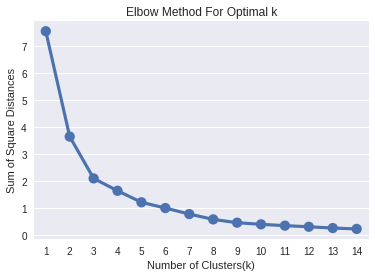

In [400]:
# elbow method for optimal k
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(X)
    sum_of_sq_dist[k] = km.inertia_
    
#  plot the graph for the sum of square distance values and number of clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [401]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
y_kmeans= kmeans.predict(X)

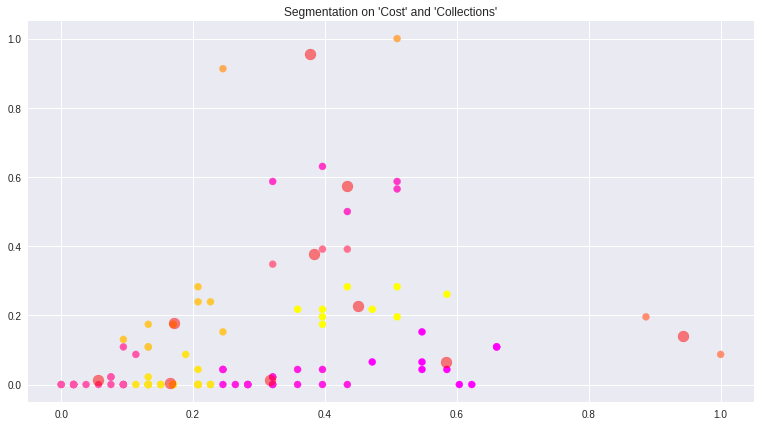

In [402]:
plt.figure(figsize=(13,7))
plt.title("Segmentation on 'Cost' and 'Collections'")
plt.scatter(df1['Cost'], df1['collections value'], c=y_kmeans, s=50, cmap='spring')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=120, alpha=0.5)

In [403]:
features = ['collections value', 'cuisines value']
X = df1[features].values
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5173745233651911
For n_clusters = 3, silhouette score is 0.5272378309793592
For n_clusters = 4, silhouette score is 0.5287530487663799
For n_clusters = 5, silhouette score is 0.5415587596551346
For n_clusters = 6, silhouette score is 0.5408473975671346
For n_clusters = 7, silhouette score is 0.4698622117797821
For n_clusters = 8, silhouette score is 0.4985018301804654
For n_clusters = 9, silhouette score is 0.49751006613187926
For n_clusters = 10, silhouette score is 0.510858073064299
For n_clusters = 11, silhouette score is 0.5131739292698656
For n_clusters = 12, silhouette score is 0.5058047319025236
For n_clusters = 13, silhouette score is 0.47717330364389093
For n_clusters = 14, silhouette score is 0.4825007457904789
For n_clusters = 15, silhouette score is 0.4991997353776495


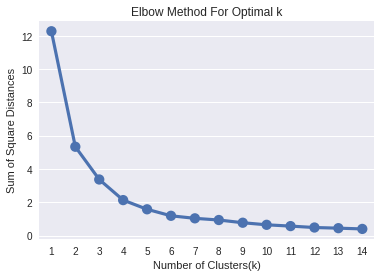

In [404]:
# elbow method for optimal k
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(X)
    sum_of_sq_dist[k] = km.inertia_
    
#  plot the graph for the sum of square distance values and number of clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [405]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
y_kmeans= kmeans.predict(X)

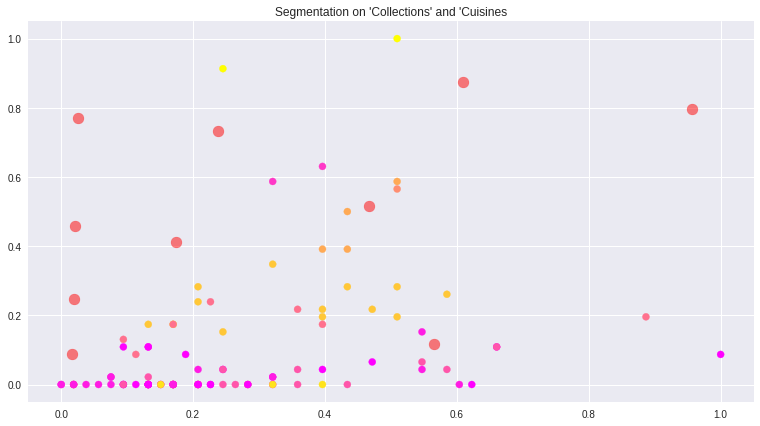

In [406]:
plt.figure(figsize=(13,7))
plt.title("Segmentation on 'Collections' and 'Cuisines")
plt.scatter(df1['Cost'], df1['collections value'], c=y_kmeans, s=50, cmap='spring')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=120, alpha=0.5)

In [408]:
features = ['cuisines value', 'Cost']
X = df1[features].values
range_n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.4881479583020236
For n_clusters = 3, silhouette score is 0.4649559455211526
For n_clusters = 4, silhouette score is 0.45487251690969854
For n_clusters = 5, silhouette score is 0.4780700275929246
For n_clusters = 6, silhouette score is 0.46769058217172443
For n_clusters = 7, silhouette score is 0.4667631791272539
For n_clusters = 8, silhouette score is 0.4417148692769214
For n_clusters = 9, silhouette score is 0.4125597128518314
For n_clusters = 10, silhouette score is 0.4071564918663346
For n_clusters = 11, silhouette score is 0.38900344750749843
For n_clusters = 12, silhouette score is 0.40867727907308676
For n_clusters = 13, silhouette score is 0.41095323983849263
For n_clusters = 14, silhouette score is 0.3872714459322761
For n_clusters = 15, silhouette score is 0.4172218230721548


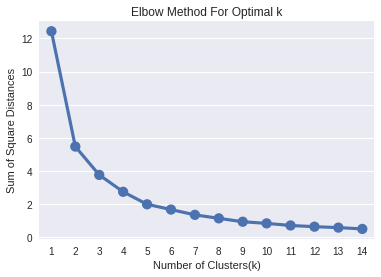

In [409]:
# elbow method for optimal k
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(X)
    sum_of_sq_dist[k] = km.inertia_
    
#  plot the graph for the sum of square distance values and number of clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [410]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
y_kmeans= kmeans.predict(X)

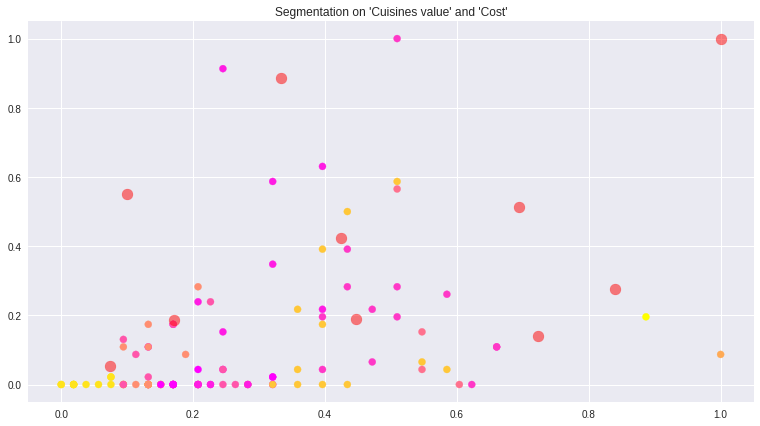

In [411]:
plt.figure(figsize=(13,7))
plt.title("Segmentation on 'Cuisines value' and 'Cost'")
plt.scatter(df1['Cost'], df1['collections value'], c=y_kmeans, s=50, cmap='spring')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=120, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


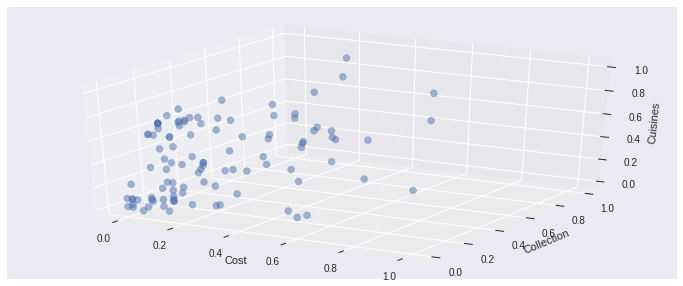

In [412]:
# 3D visualization 
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(figsize=(12,5))
plt.title('3d visualization of Cost, Collections and Cuisines')
ax=fig.add_subplot(111,projection='3d')
xs=df1['Cost']
ys=df1['collections value']
zs=df1['cuisines value']
ax.scatter(xs,ys,zs,s=50,alpha=0.5)
ax.set_xlabel('Cost')
ax.set_ylabel('Collection')
ax.set_zlabel('Cuisines')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.41604430560827255
For n_clusters = 3 The average silhouette_score is : 0.3999023844551345
For n_clusters = 4 The average silhouette_score is : 0.4163176965196534
For n_clusters = 5 The average silhouette_score is : 0.40799447524988736
For n_clusters = 6 The average silhouette_score is : 0.42873686320178583
For n_clusters = 7 The average silhouette_score is : 0.4380976643593193
For n_clusters = 8 The average silhouette_score is : 0.42816183111513456
For n_clusters = 9 The average silhouette_score is : 0.4077432358541486
For n_clusters = 10 The average silhouette_score is : 0.377108193533982


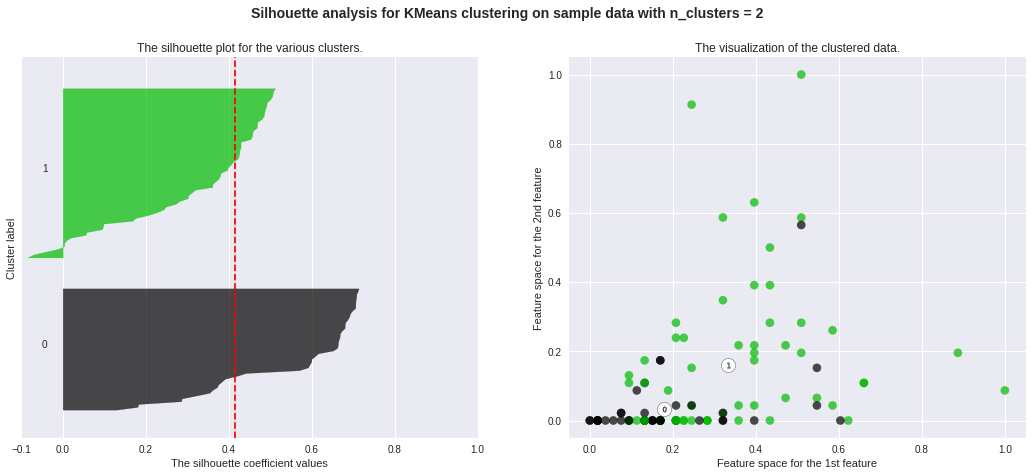

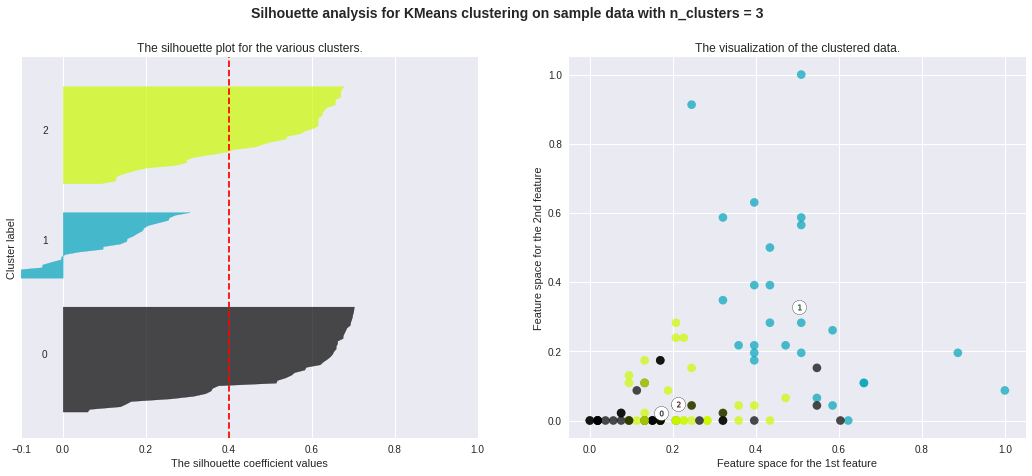

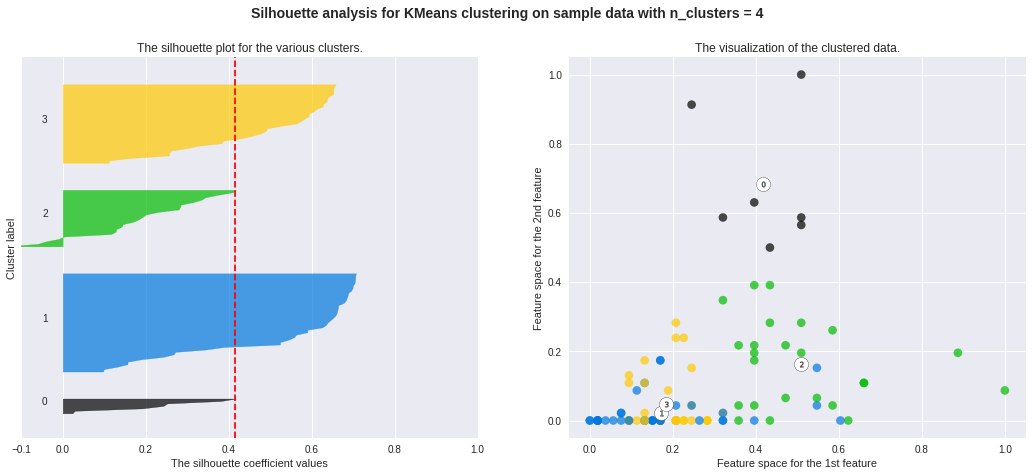

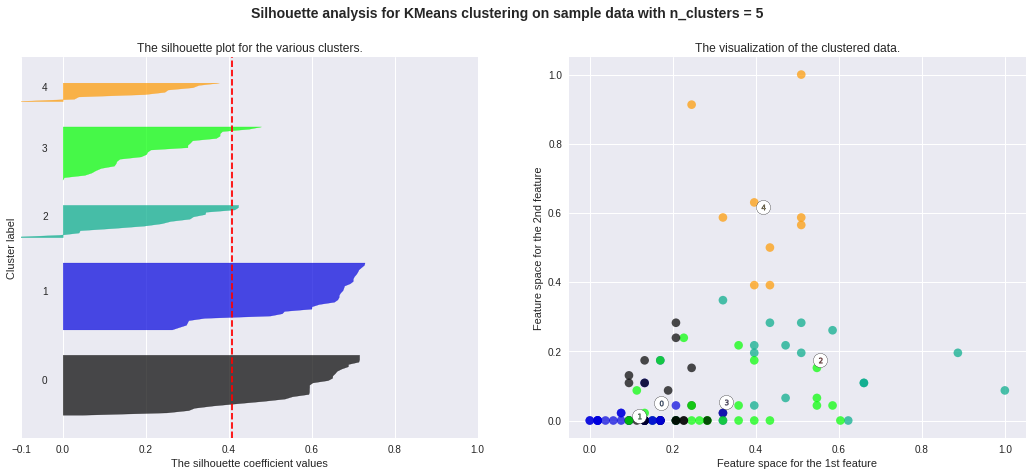

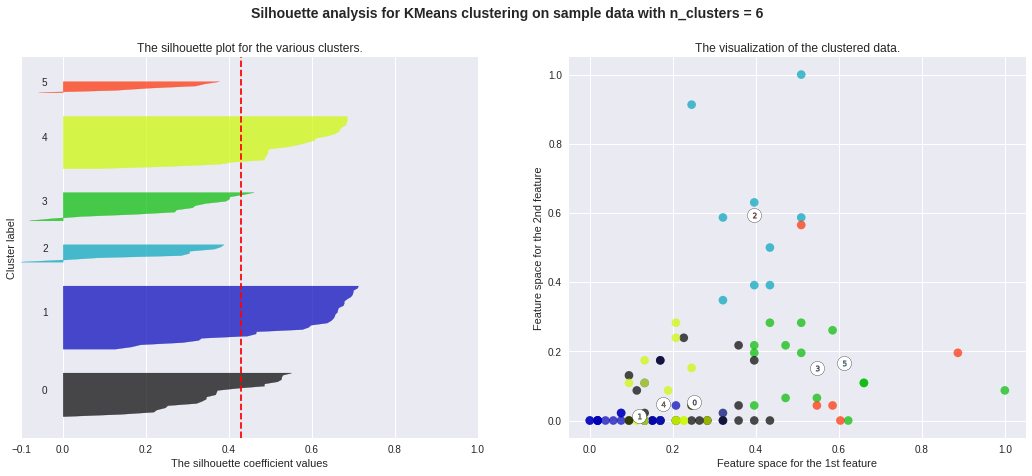

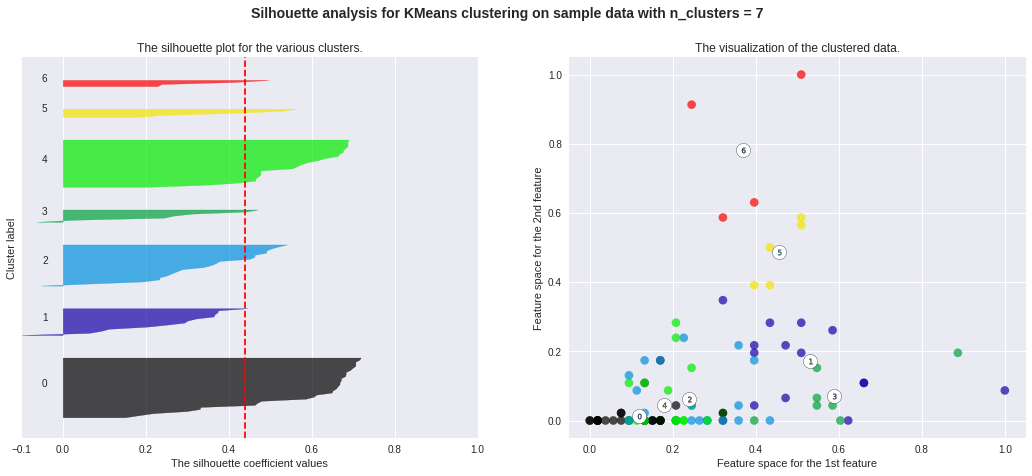

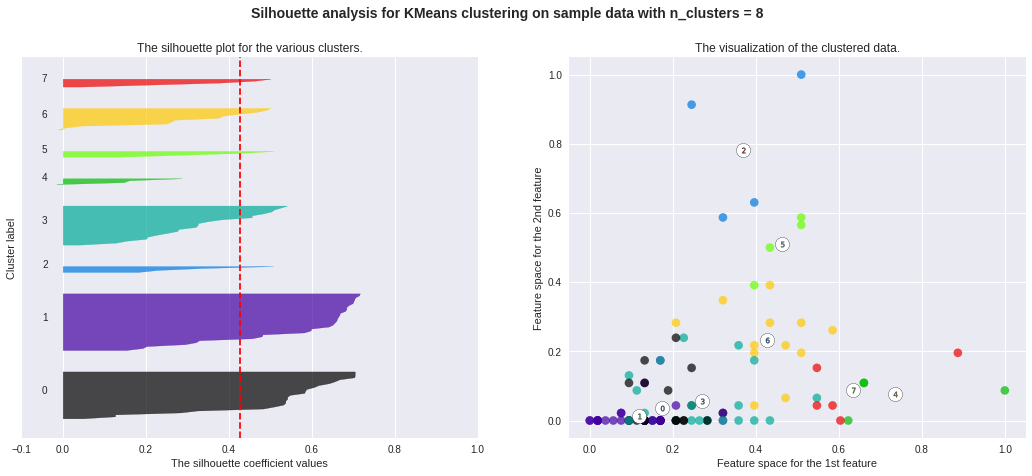

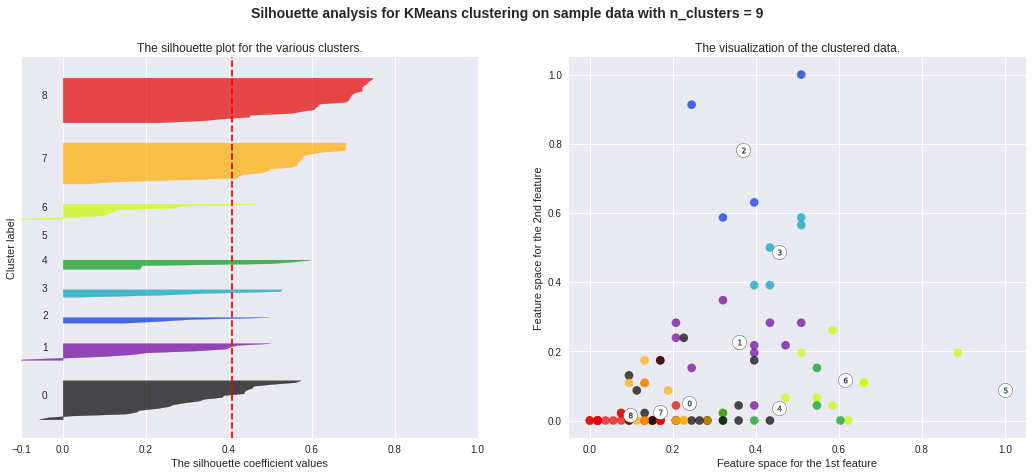

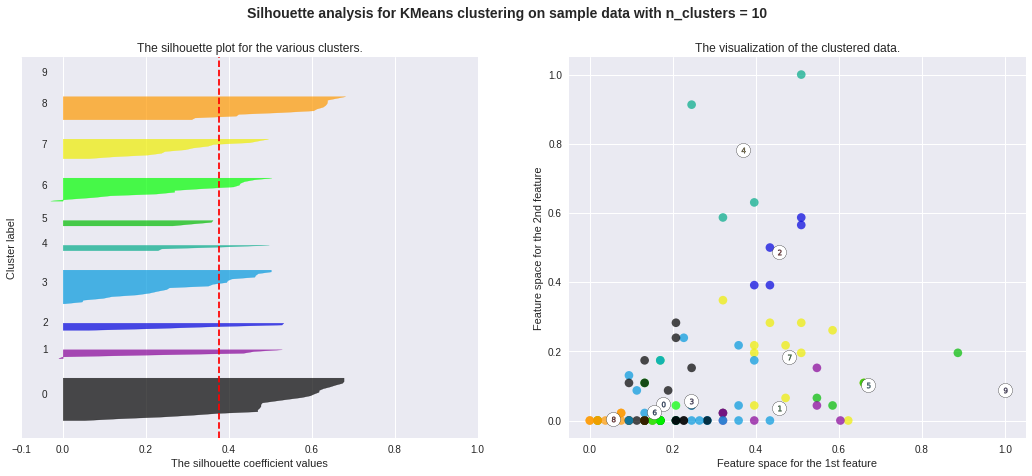

In [413]:
features = ['Cost', 'collections value', 'cuisines value']
X = df1[features].values

for n_clusters in range(2,11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) /n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=30, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### <b> Kmodes for feature 'Timings'

In [414]:
# !pip install kmodes
# from kmodes.kmodes import KModes

In [415]:
# # Elbow curve to find optimal K
# cost = []
# K = range(1,5)
# for num_clusters in list(K):
#     kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
#     kmode.fit_predict(x)
#     cost.append(kmode.cost_)
    
# plt.plot(K, cost, 'bx-')
# plt.xlabel('No. of clusters')
# plt.ylabel('Cost')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [416]:
# x.insert(0, "Cluster", clusters, True)
# x

In [417]:
# # Plot dendrogram
# import gower
# import scipy.cluster.hierarchy as sch
# plt.figure(figsize=(30,10))
# dendrogram = sch.dendrogram(sch.linkage(df1['Cost'], method = 'ward'))
# plt.title('Dendrogram')
# plt.xlabel('Restaurants')
# plt.ylabel('Euclidean Distances')
# plt.show()

In [418]:
# df1['Cost'] = df1['Cost'].str.replace(',','')
# df1['Cost'] = df1['Cost'].astype(float)

In [419]:
# X = df1['Cost']

In [420]:
# X = np.array(X).reshape(-1,1)

In [421]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(X)
# y_kmeans = kmeans.predict(X)

In [422]:
# plt.figure(figsize=(20,5))
# plt.scatter(df1['Name'], X[:, 0], c=y_kmeans, s=50, cmap='viridis')

# # centers = kmeans.cluster_centers_
# # plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)